# League of Legends Match Predictor

### Project introduction <br/>
LeLeague of Legends, a popular multiplayer online battle arena (MOBA) game, generates extensive data from matches, providing an excellent opportunity to apply machine learning techniques to real-world scenarios. I will be building a logistic regression model aimed at predicting the outcomes of League of Legends matches.  

Use the [league_of_legends_data_large.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rk7VDaPjMp1h5VXS-cUyMg/league-of-legends-data-large.csv) file to perform the tasks. 

In [10]:
import pandas as pd  # Import pandas for data manipulation
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling
import torch  # Import torch for tensor operations

data = pd.read_csv('games.csv')   # Load the dataset into a pandas DataFrame

data.head()


,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In [11]:
# Drop columns that are IDs or timestamps and not useful for prediction
data = data.drop(['gameId', 'creationTime'], axis=1)

# Optionally, drop categorical columns like bans if you don't plan to encode them yet
ban_cols = [col for col in data.columns if 'ban' in col]
data = data.drop(ban_cols, axis=1)

# Convert winner column to 0 (team 2 win) and 1 (team 1 win)
y = (data['winner'] == 1).astype(float)  # 1 if winner==1, 0 if winner==2

# Continue as before
X = data.drop('winner', axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [12]:
import torch.nn as nn  # Import torch.nn for neural network modules

class LogisticRegressionModel(nn.Module):  # Define a class for the logistic regression model
    def __init__(self, input_dim):  # Constructor takes input_dim (number of features)
        super(LogisticRegressionModel, self).__init__()  # Call the parent class constructor
        self.linear = nn.Linear(input_dim, 1)  # Single linear layer for logistic regression

    def forward(self, x):  # Define the forward pass
        return torch.sigmoid(self.linear(x))  # Apply sigmoid activation to linear output

input_dim = X_train.shape[1]  # Get the number of features from training data

model = LogisticRegressionModel(input_dim)  # Instantiate the logistic regression model
criterion = nn.BCELoss()  # Use binary cross-entropy loss for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Use SGD optimizer with learning rate 0.01

In [13]:
epochs = 1000  # Set the number of training epochs

for epoch in range(epochs):  # Loop over the number of epochs
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Zero the gradients before each batch
    outputs = model(X_train).squeeze()  # Forward pass: get model predictions for training data
    loss = criterion(outputs, y_train)  # Compute the loss between predictions and true labels
    loss.backward()  # Backpropagation: compute gradients
    optimizer.step()  # Update model parameters using gradients

    if (epoch + 1) % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    train_preds = (model(X_train).squeeze() >= 0.5).float()  # Predict on training set (threshold 0.5)
    train_acc = (train_preds == y_train).float().mean().item()  # Calculate training accuracy

    test_preds = (model(X_test).squeeze() >= 0.5).float()  # Predict on test set (threshold 0.5)
    test_acc = (test_preds == y_test).float().mean().item()  # Calculate test accuracy

print(f"Training Accuracy: {train_acc * 100:.2f}%")  # Print training accuracy
print(f"Test Accuracy: {test_acc * 100:.2f}%")  # Print test accuracy

Epoch [100/1000], Loss: 0.3715
Epoch [200/1000], Loss: 0.2752
Epoch [300/1000], Loss: 0.2351
Epoch [400/1000], Loss: 0.2125
Epoch [500/1000], Loss: 0.1978
Epoch [600/1000], Loss: 0.1874
Epoch [700/1000], Loss: 0.1795
Epoch [800/1000], Loss: 0.1733
Epoch [900/1000], Loss: 0.1683
Epoch [1000/1000], Loss: 0.1641
Training Accuracy: 94.76%
Test Accuracy: 94.81%


In [14]:
model_l2 = LogisticRegressionModel(input_dim)  # Re-instantiate the model for L2 regularization
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=0.01, weight_decay=0.01)  # Add weight_decay for L2

for epoch in range(epochs):  # Loop over epochs
    model_l2.train()  # Set model to training mode
    optimizer_l2.zero_grad()  # Zero the gradients
    outputs = model_l2(X_train).squeeze()  # Forward pass
    loss = criterion(outputs, y_train)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer_l2.step()  # Update parameters

    if (epoch + 1) % 100 == 0:  # Print loss every 100 epochs
        print(f"[L2] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

model_l2.eval()  # Set model to evaluation mode
with torch.no_grad():  # No gradients needed for evaluation
    train_preds_l2 = (model_l2(X_train).squeeze() >= 0.5).float()  # Predict on training set
    train_acc_l2 = (train_preds_l2 == y_train).float().mean().item()  # Training accuracy
    test_preds_l2 = (model_l2(X_test).squeeze() >= 0.5).float()  # Predict on test set
    test_acc_l2 = (test_preds_l2 == y_test).float().mean().item()  # Test accuracy

print(f"[L2] Training Accuracy: {train_acc_l2 * 100:.2f}%")  # Print L2 training accuracy
print(f"[L2] Test Accuracy: {test_acc_l2 * 100:.2f}%")  # Print L2 test accuracy

[L2] Epoch [100/1000], Loss: 0.3441
[L2] Epoch [200/1000], Loss: 0.2683
[L2] Epoch [300/1000], Loss: 0.2346
[L2] Epoch [400/1000], Loss: 0.2149
[L2] Epoch [500/1000], Loss: 0.2017
[L2] Epoch [600/1000], Loss: 0.1921
[L2] Epoch [700/1000], Loss: 0.1847
[L2] Epoch [800/1000], Loss: 0.1789
[L2] Epoch [900/1000], Loss: 0.1742
[L2] Epoch [1000/1000], Loss: 0.1702
[L2] Training Accuracy: 94.58%
[L2] Test Accuracy: 94.69%


Confusion Matrix:
 [[4704  363]
 [ 184 5047]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      5067
           1       0.93      0.96      0.95      5231

    accuracy                           0.95     10298
   macro avg       0.95      0.95      0.95     10298
weighted avg       0.95      0.95      0.95     10298



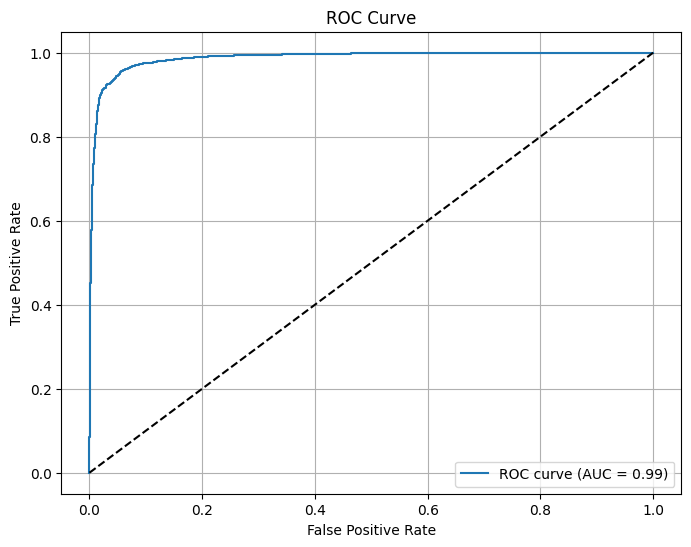

In [15]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report  # Import metrics for evaluation
import matplotlib.pyplot as plt  # Import matplotlib for plotting

with torch.no_grad():  # No gradients needed for evaluation
    test_probs = model_l2(X_test).squeeze().numpy()  # Get predicted probabilities for ROC
    test_preds = (test_probs >= 0.5).astype(int)  # Get binary predictions
    y_test_np = y_test.numpy().astype(int)  # Convert test labels to numpy array

cm = confusion_matrix(y_test_np, test_preds)  # Compute confusion matrix
print("Confusion Matrix:\n", cm)  # Print confusion matrix

print("Classification Report:\n", classification_report(y_test_np, test_preds))  # Print classification report

fpr, tpr, thresholds = roc_curve(y_test_np, test_probs)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute AUC

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')  # Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel('False Positive Rate')  # X-axis label
plt.ylabel('True Positive Rate')  # Y-axis label
plt.title('ROC Curve')  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display plot